# Brain MRI Inpainting

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Hobit2002/BraTS_JKU_10a/blob/main/Colab_interface.ipynb)

## Clone the repository

In [ ]:
!git clone https://github.com/github/Hobit2002/BraTS_JKU_10a.git
!cd BraTS_JKU_10a
!git checkout main
!cd baseline


Cloning into 'brats_challenge'...
remote: Enumerating objects: 311, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 311 (delta 22), reused 8 (delta 3), pack-reused 262 (from 1)
Receiving objects: 100% (311/311), 6.80 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/bin/bash: line 1: cd: 2023_challenge: No such file or directory
fatal: not a git repository (or any of the parent directories): .git
/bin/bash: line 1: cd: baseline: No such file or directory


## Install the dependencies

In [ ]:
# ## Install the dependencies
!pip uninstall -y  torch torchvision torchaudio
!pip install  --no-cache-dir torch --index-url https://download.pytorch.org/whl/cu118
!pip install --no-cache-dir torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install --no-cache-dir torchaudio --index-url https://download.pytorch.org/whl/cu118
# For CUDA 11.7, use cu117 instead of cu118 in the above command.  Adjust accordingly for other CUDA versions.
# If you have issues with CUDA, try installing without CUDA:
# !pip install torch torchvision torchaudio

!pip install pytorch-lightning
!pip install matplotlib
!pip install nibabel
!pip install tensorboard
!pip install jupyter
!pip install scipy
!pip install tqdm


Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 238.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 322.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 253.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 254.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 225.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 169.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download the dataset

In [ ]:
import requests
import zipfile
import io
import os

# Download the zip file
url = "http://pytlik.pruzor.cz/ASNR-MICCAI-BraTS2023-Local-Synthesis-Challenge-Training.zip"
response = requests.get(url, stream=True)
response.raise_for_status()  # Raise an exception for bad status codes

# Create the extraction directory if it doesn't exist
extract_dir = "/content/BraTS_JKU_10a"
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(extract_dir)

Mounted at /content/drive


## Imports and Parameters

In [ ]:
import os

os.chdir("/content/brats_challenge/baseline")

# Diverse
from pathlib import Path
import numpy as np
from tqdm import tqdm

# Datasets
from dataset3D import Dataset_Training, Dataset_Inference

# Training
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from baseline_utils import plot_3D
import nibabel as nib

# Models
from baseline_utils import get_latest_Checkpoint  # to load last checkpoint
from train_Pix2Pix3D import Pix2Pix3D
from train_AE import AutoEncoder

# Processes
import subprocess
import sys

# Path to training dataset
dataset_path = Path("../ASNR-MICCAI-BraTS2023-Local-Synthesis-Challenge-Training")

# Seed (For the random number generator. Use this seed to reproduce our output)
seed = 2023
np.random.seed(2023)  # set seed for notebook.

# Crop shape (how big is the cuboid the network is trained on)
crop_shape = (128, 128, 96)  # most bounding boxes should fit easily into this volume


### Inspect the data
---



In [ ]:
datasetInf = Dataset_Inference(dataset_path, crop_shape=(240, 240, 155))  # Full images
datasetTrain = Dataset_Training(dataset_path, crop_shape=(240, 240, 155))  # Full images


print(f"Dataset size: {len(datasetTrain)}")
print(f"\tImage shape: {datasetTrain[0]['voided_healthy_image'].shape}")
# Shape: Channel x X(Width) x Y(length/Depth) x Z(Height) -> CWDH

print(f"Training Data: {list(datasetTrain[0].keys())}")
print(f"Inference Data: {list(datasetInf[0].keys())}")

Dataset size: 6
	Image shape: torch.Size([1, 240, 240, 155])
Training Data: ['gt_image', 'voided_healthy_image', 't1n_path', 'healthy_mask', 'healthy_mask_path', 'cropped_bbox', 'max_v', 'name']
Inference Data: ['voided_image', 't1n_voided_path', 'mask', 'cropped_bbox', 'max_v', 'name']


### Example Figure: Full Brain Sample

Lets create a dataset with complete (full size) brain samples (**240x240x155**) to get an idea how the samples looks like.

However, for training our baseline model, full sized brain samples are **too big**! We use cropped brain samples (see next section).


BraTS-GLI-01662-000: t1n + mask-healthy:


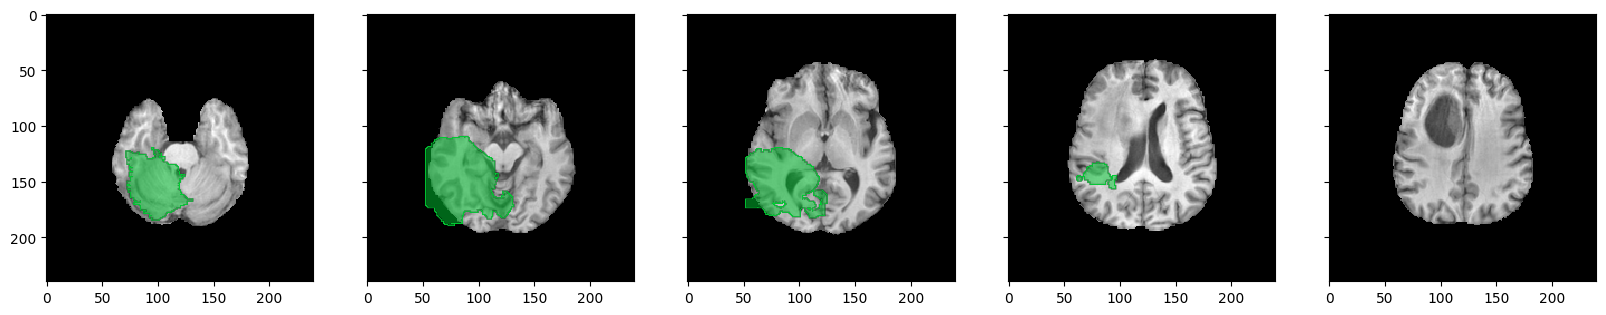

BraTS-GLI-01662-000: t1n-voided-healthy:


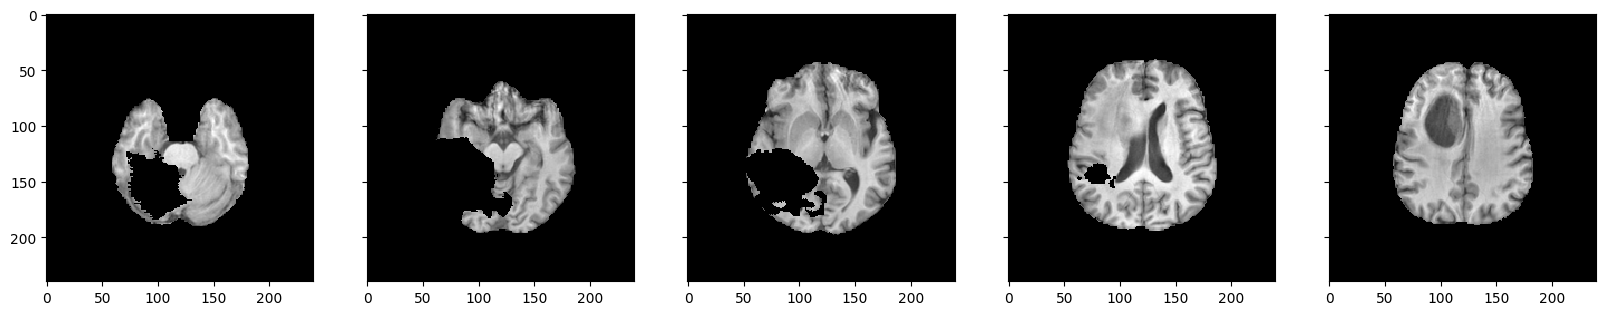

In [ ]:
# Get random sample
random_index = np.random.randint(0, len(datasetTrain) - 1)
sample_data = datasetTrain[random_index]

# Plot: t1n, t1n-voided-healthy
print(f"{sample_data['name']}: t1n + mask-healthy:")
plot_3D(sample_data["gt_image"], healthyMask=sample_data["healthy_mask"])
print(f"{sample_data['name']}: t1n-voided-healthy:")  # t1n where the healthy mask is voided
plot_3D(sample_data["voided_healthy_image"])

## Training - Pix2Pix

As training in this notebook might be cumbersome (and not easily transferable to an HPC server), we outsource the training into ```baseline/train_Pix2Pix3D.py```.
In the following, we define the parameters for training and start a subprocess for training with them as arguments.

In case you **struggle** with setting up Pix2Pix, you might want to first to get the **Autoencoder** running (next section). It is less complex, needs less VRAM and training should be faster.

In [ ]:
!python3 train_Pix2Pix3D.py --epochs 3 --dataset ../sample_scans --batch-size 2 --accelerator gpu --gpus 0 --seed 2023 --split 0.8 0.2 --crop-shape 128 128 96 --ckpt-path None

Namespace(epochs=3, batch_size=2, dataset_path='../sample_scans', accelerator='gpu', gpus=[0], seed=2023, split=[0.8, 0.2], crop_shape=[128, 128, 96], ckpt_path='None')
Running on gpu:
	[0]: NVIDIA A100-SXM4-40GB
Seed: 2023
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
######################################
experiment_name: Pix2Pix3D
######################################
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize t